# Estimating Pillar Volume
---
**Author**: Ryan Lane  
**Date**: 18 June 2023

#### Overview
Cristiano asked me to analyze the heights of some of his pillars. Involves segmenting the images and estimating the volume of each pillar. Segmentation was done in GIMP. Was not able to segment `A3_50j1T_001.tif` or `D1_49d1T_001.tif`.

#### Assumptions
* Each image contains 9 pillars (not always true).
* No dynamic focus or tilt correction.
  * I checked metadata for `DynamicFocusIsOn` and `TiltCorrectionIsOn` attributes, all were `no`.

In [1]:
from pathlib import Path
from itertools import product

from tqdm.notebook import tqdm
from natsort import natsorted
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Polygon, Ellipse

from skimage import io, exposure, measure, color
from tifffile import TiffFile

from pillars import measure_volume, sort_pillars, plot_pillars

#### Utility functions

In [2]:
def get_metadata(
    filepath,
    ignore_tags=("StripByteCounts", "StripOffsets")
):
    """Return tiff metadata as a dict"""
    # Read tif file
    tif = TiffFile(filepath)
    # Parse tif tags in a dict comprehension
    metadata = {k.name: k.value for k in tif.pages[0].tags \
                if k.name not in ignore_tags}
    return metadata

#### Organize data

In [3]:
# Glob pillar images
fps_raw = natsorted(Path("../images_raw/").glob("*.tif"))
fps_msk = natsorted(Path("../images_processed/").glob("*.png"))

# Organize into DataFrame
df_fps = pd.DataFrame({
    "fp_raw": fps_raw,
    "fp_msk": fps_msk
})

# Loop through filepaths to add more info to DataFrame
for i, row in tqdm(
    df_fps.iterrows(),
    total=len(df_fps)
):

    # Get some names down in case they are relevant later for grouping
    df_fps.loc[i, "name"] = row["fp_raw"].stem
    df_fps.loc[i, "s1"] = row["fp_raw"].stem.split("_")[0]
    df_fps.loc[i, "s2"] = row["fp_raw"].stem.split("_")[1]

    # Determine if image was processed based on file size ( < 1 MB )
    df_fps.loc[i, "processed"] = Path.stat(row["fp_msk"]).st_size < 1e6

    # Parse metadata for pixelsize (psx == psy) and stage tilt
    metadata = get_metadata(row["fp_raw"])
    df_fps.loc[i, "pixelsize"] = metadata["FEI_HELIOS"]["EScan"]["PixelWidth"]
    df_fps.loc[i, "tilt"] = metadata["FEI_HELIOS"]["Stage"]["StageT"]

# Preview
df_fps.head()

  0%|          | 0/21 [00:00<?, ?it/s]

,fp_raw,fp_msk,name,s1,s2,processed,pixelsize,tilt
0,..\images_raw\A3_50g1T_001.tif,..\images_processed\A3_50g1T_001.png,A3_50g1T_001,A3,50g1T,True,2.697920e-09,0.785379
1,..\images_raw\A3_50h1T45_001.tif,..\images_processed\A3_50h1T45_001.png,A3_50h1T45_001,A3,50h1T45,True,3.854170e-09,0.785379
2,..\images_raw\A3_50h1T_001.tif,..\images_processed\A3_50h1T_001.png,A3_50h1T_001,A3,50h1T,True,2.697920e-09,0.785379
3,..\images_raw\A3_50i1T45_001.tif,..\images_processed\A3_50i1T45_001.png,A3_50i1T45_001,A3,50i1T45,True,3.854170e-09,0.785379
4,..\images_raw\A3_50i1T_001.tif,..\images_processed\A3_50i1T_001.png,A3_50i1T_001,A3,50i1T,True,2.697920e-09,0.785379


## Analysis
---

### Volume measurements

|          |                           |                                                                                                               |
|----------|---------------------------|---------------------------------------------------------------------------------------------------------------|
| cone     | $V = \frac{\pi}{3} r^2 z$ | $\sigma_V = \sqrt{\left(\frac{\pi z}{3} r\right)^2 {\sigma_r}^2 + \left(\frac{\pi r}{6}\right)^2 {\sigma_z}^2}$ |
| cylinder | $V = \pi r^2 z$           | $\sigma_V = \sqrt{(\pi z r)^2 {\sigma_r}^2 + \left(\frac{\pi r}{2}\right)^2 {\sigma_z}^2}$                      |
| pillar   | $V = \int \pi r^2 dz$     | $\sigma_V = \sqrt{(\pi z r)^2 {\sigma_r}^2 + \left(\frac{\pi r}{2}\right)^2 {\sigma_z}^2}$                      |

#### Error
Error in volume measurement is estimated by error propagation [1] of small ($\pm$ 1px) deviations in measurements of radius and height from the segmentation.
\begin{equation}
    \sigma_V = \sqrt{\left(\frac{\partial V}{\partial r}\right)^2 {\sigma_r}^2 + \left(\frac{\partial V}{\partial z}\right)^2 {\sigma_z}^2}
\end{equation}

**Reference**  
[1] [Error propagation](https://en.wikipedia.org/wiki/Propagation_of_uncertainty#Simplification)

#### Demo on random image

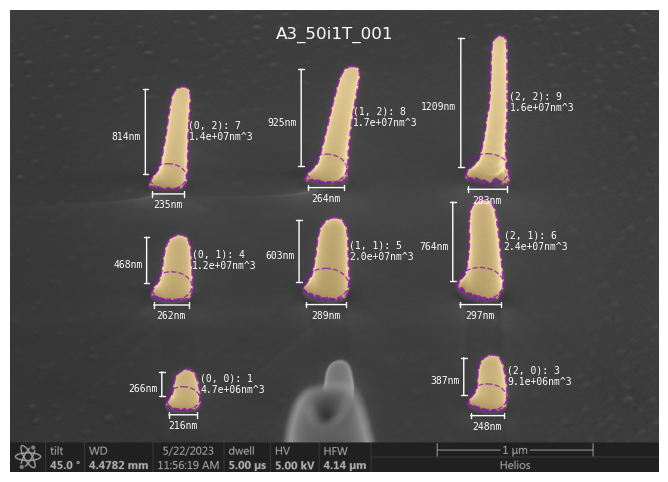

In [4]:
# Choose measurement method
method = "pillar"
area_min = 100

# Random sample
# row = df_fps.sample(1, random_state=85).iloc[0]
row = df_fps.iloc[4]
# row = df_fps.loc[df_fps["name"] == "B1_52c2T"].iloc[0]

# Load image and mask
image = TiffFile(row["fp_raw"]).pages[0].asarray()
mask = io.imread(row["fp_msk"])

# Plot
pillars = plot_pillars(
    image=image,
    mask=mask,
    pixelsize=row["pixelsize"] * 1e9,
    theta=row["tilt"],
    method=method,
    area_min=area_min,
    title=row["name"],
)

## Batch process all images | Measurements
---

Measure the volume of each pillar in each image with each measurement strategy. Output results to `./results/results.csv`

In [5]:
# Set parameters
area_min = 100

# Initialize DataFrame
df_res = pd.DataFrame()
j = 0  # set counter

# Loop through all images
for i, row in tqdm(
    df_fps.iterrows(),
    total=len(df_fps)
):

    # Skip over non-processed
    if not row["processed"]:
        continue
    # Skip over the rotated ones
    if ("45" in row["s2"]) and (row["pixelsize"] > 3e-9):
        continue

    # Load image and mask
    image = TiffFile(row["fp_raw"]).pages[0].asarray()
    mask = io.imread(row["fp_msk"])

    # Process masks
    labels = measure.label(mask > 65535/2)
    # Collect segments from labelled image
    segments = measure.regionprops(labels)
    # Assume 9 largest segments are pillars
    pillars = sorted(
        segments,
        key=lambda x: x.area,
        reverse=True
    )[:9]
    # Filter out teeny tiny pillars
    pillars = [p for p in pillars if p.area > area_min]
    # Sort pillars into grid
    pillars_grid = sort_pillars(pillars)

    # Loop through pillars
    for (cc, rr), pillar in pillars_grid.items():

        # Loop through volume measurement methods
        for method in ["cone", "cylinder", "pillar"]:

            # Measure pillar
            measurements = measure_volume(
                pillar=pillar,
                pixelsize=1e9*row["pixelsize"],
                theta=row["tilt"],
                method=method
            )
            # Unpack measurements
            (x1, x2), (y1, y2), (xc, yb), width, height, volume, sigma_h, sigma_v = measurements

            # Get pillar number from grid position
            mapping = {v: k+1 for k, v in enumerate(product(range(3), range(3)))}
            p = mapping[(rr, cc)]

            # Add to DataFrame
            df_res.loc[j, "filename"] = row["name"]
            df_res.loc[j, "pillar #"] = p
            df_res.loc[j, "method"] = method
            df_res.loc[j, "width (nm)"] = width
            df_res.loc[j, "height (nm)"] = height
            df_res.loc[j, "volume (nm^3)"] = volume
            df_res.loc[j, "error height (nm)"] = sigma_h
            df_res.loc[j, "error volume (nm^3)"] = sigma_v
            j += 1  # increment counter

# Save results
df_res.to_csv("../results/results.csv", index=False)
df_res.head()

  0%|          | 0/21 [00:00<?, ?it/s]

,filename,pillar #,method,width (nm),height (nm),volume (nm^3),error height (nm),error volume (nm^3)
0,A3_50g1T_001,1.0,cone,67.44800,290.592902,3.460922e+05,3.815508,13843.850986
1,A3_50g1T_001,1.0,cylinder,67.44800,290.592902,1.038277e+06,3.815508,41531.552958
2,A3_50g1T_001,1.0,pillar,67.44800,290.592902,7.893852e+05,3.815508,83062.368168
3,A3_50g1T_001,2.0,cone,64.75008,360.621061,3.958224e+05,3.815508,16492.725470
4,A3_50g1T_001,2.0,cylinder,64.75008,360.621061,1.187467e+06,3.815508,49478.176409


## Batch process all images | Plots
---

Measure the volume of each pillar in each image with each measurement strategy, generate the plot and save the figure. Output plots to `./results/{measurement}/{image}.png`

In [6]:
# Loop through all images
for i, row in tqdm(
    df_fps.iterrows(),
    total=len(df_fps)
):

    # Skip over non-processed
    if not row["processed"]:
        continue
    # Skip over the rotated ones
    if ("45" in row["s2"]) and (row["pixelsize"] > 3e-9):
        continue

    # Load image and mask
    image = TiffFile(row["fp_raw"]).pages[0].asarray()
    mask = io.imread(row["fp_msk"])

    # Loop through measurement methods
    for method in ["cone", "cylinder", "pillar"]:

        # Set directory to store output
        dir_out = Path(f"../results/{method}s/")
        dir_out.mkdir(exist_ok=True, parents=False)

        # Plot and save figures
        plot_pillars(
            image=image,
            mask=mask,
            pixelsize=row["pixelsize"] * 1e9,
            theta=row["tilt"],
            method=method,
            area_min=area_min,
            title=row["name"],
            filename=dir_out / f"{row['name']}.png",
            dpi=300
        )
        plt.close()

  0%|          | 0/21 [00:00<?, ?it/s]